In [1]:
import numpy as np
import open3d as o3d
from matplotlib import pyplot as plt
from PIL import Image, ImageFilter
from scipy import signal
import skfmm

import PointCloudMask as pcm

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
leafs = pcm.apply_depth_mask("PCDandDepth/Pointclouds/demo_ (1).pcd", 'PCDandDepth/Images/aggrigated_masks (1).png',
                             "PCDandDepth/Arrays/depth (1).npy", plot=False)

In [25]:
print(leafs.shape)

(1080, 1440, 4)


Test 1: Performing convolution with needle array to erode away leaf edges

average kernel size:  38.0
average kernel size:  39.0
average kernel size:  37.0
average kernel size:  39.0
average kernel size:  38.0
average kernel size:  40.0
average kernel size:  39.0
average kernel size:  39.0
average kernel size:  39.0
average kernel size:  38.0
average kernel size:  40.0
all kernels:  [38.0, 39.0, 37.0, 39.0, 38.0, 40.0, 39.0, 39.0, 39.0, 38.0, 40.0]


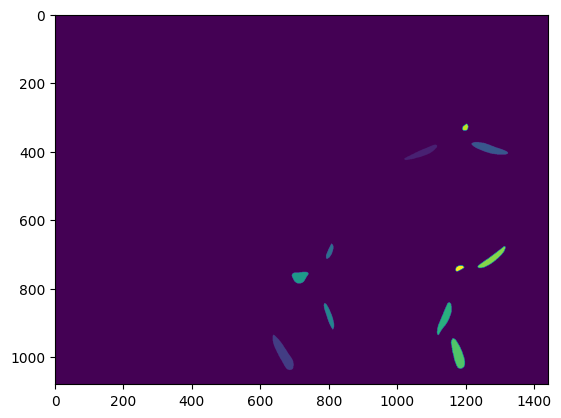

In [6]:
depth_image = leafs[:,:,2].astype('float32')
mask_image = leafs[:,:,3].astype('uint8')
kernels = get_kernels(depth_image, mask_image, leafs)
no_leaves = np.unique(mask_image)
graspable_mask = do_convolution(kernels, mask_image)
plt.imshow(graspable_mask)

In [5]:
def get_kernels(depth_image, mask_image, masked_points):
    masks_ind = np.unique(mask_image)
    kernels = []
    
    for i in range(1, len(masks_ind)):
        singular_leaf_mask = np.where(mask_image, mask_image == masks_ind[i], 0)
        leaf_mask = singular_leaf_mask * depth_image
        kernel_ = kernel_size(leaf_mask, plot=False)
        kernels.append(kernel_)
    print('all kernels: ', kernels)
    return kernels
        

In [4]:
def kernel_size(depth_mask, plot=False):
    calib_projection_matrix = np.array(([1722.235253, 0, 584.315697, 0],
                           [0, 1722.235253, 488.690098, 0],
                           [0, 0, 1, 0, ]))
    P = np.reshape(calib_projection_matrix, (3,4))
    X = np.ones((4,1))

    leaf_x = np.nonzero(depth_mask)[0]
    leaf_y = np.nonzero(depth_mask)[1]
    mean_depth = np.mean(depth_mask[leaf_x,leaf_y])


    depth = np.array(([0,0, mean_depth]))
    mn_dim = 0.005
    d1 = np.array(([-mn_dim / 2, -mn_dim / 2, mean_depth]))
    d2 = np.array(([mn_dim / 2, -mn_dim / 2, mean_depth]))
    d3 = np.array(([-mn_dim / 2, mn_dim / 2, mean_depth]))
    d4 = np.array(([mn_dim / 2, mn_dim / 2, mean_depth]))
    Dc = np.array([depth]).transpose()
    D1 = np.array([d1]).transpose()
    D2 = np.array([d2]).transpose()
    D3 = np.array([d3]).transpose()
    D4 = np.array([d4]).transpose()
    X[0:3, :] = np.array(Dc)
    x = np.matmul(P, X)
    xc = x / x[-1:]
    X[0:3, :] = np.array(D1)
    x = np.matmul(P, X)
    x1 = x / x[-1:]
    X[0:3, :] = np.array(D2)
    x = np.matmul(P, X)
    x2 = x / x[-1:]
    X[0:3, :] = np.array(D3)
    x = np.matmul(P, X)
    x3 = x / x[-1:]
    X[0:3, :] = np.array(D4)
    x = np.matmul(P, X)
    x4 = x / x[-1:]

    sz_1 = np.abs(np.round(x1[0]) - np.round(x2[0]))
    sz_2 = np.abs(np.round(x1[1]) - np.round(x3[1]))
    sz_3 = np.abs(np.round(x4[0]) - np.round(x3[0]))
    sz_4 = np.abs(np.round(x4[1]) - np.round(x2[1]))

    kernel_ = np.round(np.average(([sz_1, sz_2, sz_3, sz_4])))  # this is just a length of a square

    print('average kernel size: ', kernel_)

    if plot:
            plt.imshow(depth_mask)
            plt.plot(np.round(xc[0]), np.round(xc[1]), 'r.')
            plt.plot(np.round(x1[0]), np.round(x1[1]), 'r.')
            plt.plot(np.round(x2[0]), np.round(x2[1]), 'r.')
            plt.plot(np.round(x3[0]), np.round(x3[1]), 'r.')
            plt.plot(np.round(x4[0]), np.round(x4[1]), 'r.')
            plt.show()
    return kernel_

In [3]:
def do_convolution(kernel, mask):

    kernel_ = kernel
    mask_ = mask
    index_ = np.unique(mask_)
    
    graspable_areas = np.zeros((1080, 1440))
    
    for i in range(1, len(index_)):
        mask_local_ = mask_ == index_[i]
        mask_local_ = np.where(mask_local_, mask_local_ >= 1, 0)
        graspable_area = signal.convolve2d(mask_local_.astype('uint8'), np.ones((kernel_[i - 1].astype('uint8'), kernel_[i - 1].astype('uint8'))), boundary='symm',
                                               mode='same')
        graspable_area = np.where(graspable_area, graspable_area < np.amax(graspable_area)*.9,
                                      1)  # remove blurry parts
        graspable_area_ = np.logical_not(graspable_area).astype(
                int)
        i_, j_ = np.where(graspable_area_ == np.amax(graspable_area_))
        graspable_areas[i_, j_] = i
    return graspable_areas
        
   

In [29]:

binary_grasp_mask = graspable_mask >=1
leafs[:,:,0] = leafs[:,:,0]*binary_grasp_mask
leafs[:,:,1] = leafs[:,:,1]*binary_grasp_mask
leafs[:,:,2] = leafs[:,:,2]*binary_grasp_mask
leafs[:,:,3] = leafs[:,:,3]*binary_grasp_mask
leafs_ = np.reshape(leafs[:,:,0:3], (1555200, 3))
print(leafs_.shape)
index = np.argwhere(leafs_ == [0,0,0])
inverse_index = np.nonzero(leafs_[:,2])
leafs__ = np.delete(leafs_, index,0)
print(leafs__.shape)
print(inverse_index)


(1555200, 3)
(14092, 3)
(array([ 463440,  463441,  463442, ..., 1495405, 1495406, 1495407]),)


In [8]:

processed_pcd = o3d.geometry.PointCloud()
processed_pcd.points = o3d.utility.Vector3dVector(leafs__)

In [11]:
#processed_pcd.estimate_normals(
   # search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.01, max_nn=30)
#)
o3d.visualization.draw_geometries([processed_pcd])

In [9]:
pcm.compute_normals(processed_pcd)
sqrt_dist = np.sum((processed_pcd.normals[999])**2, axis=0)
dist = np.sqrt(sqrt_dist)
normal_orientation = np.asarray(processed_pcd.normals)[:,2]
normal_orientation = abs(normal_orientation)
print(max(normal_orientation))
orientation_color = np.zeros((len(normal_orientation), 3))
orientation_color[:,0]=normal_orientation
orientation_color[:,1]=0
orientation_color[:,2]=0
processed_pcd.colors = o3d.utility.Vector3dVector(orientation_color)

Computing Normals!
0.999994218226358


In [10]:
o3d.visualization.draw_geometries([processed_pcd])

In [30]:
leaf_flatness = np.zeros((1555200, 1))
print(leaf_flatness.shape)
print(normal_orientation.shape)
j=0
for i in inverse_index[0]:
    leafs_[i,0] = normal_orientation[j]
    j+1

(1555200, 1)
(14092,)


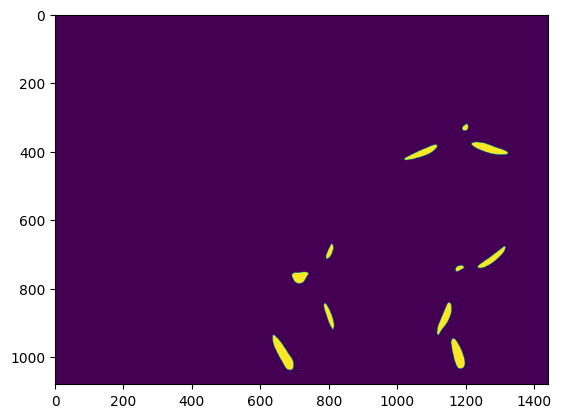

In [45]:
leafs_orient = np.reshape(leafs_, (1080,1440,3))
plt.imshow(leafs_orient[:,:,0])